In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-09-05 12:27:51.117234: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-05 12:27:51.118612: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-05 12:27:51.142156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-05 12:27:51.142608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-05 12:27:51.539434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [3]:
import tensorflow as tf
print("Devices:", tf.config.list_physical_devices())


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-09-05 12:27:56.323136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-05 12:27:56.323678: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
from sklearn.preprocessing import MinMaxScaler


my_file = "./Nmetil.MDE"
df = pd.read_csv(
    my_file,
    sep=r"\s+",
    comment='#',
    names=["Step", "T", "E_KS", "E_tot", "Vol", "P"]
)

rows_per_group = 900

# Adauga pozitia in grup in df
df['pos_in_group'] = df.groupby('Step').cumcount()

# # Varianta 1: for + concat
# start_for = time.time()
# df_data_for = pd.DataFrame()
# for i in df['Step'].unique():
#     df1 = df[df['Step'] == i].reset_index(drop=True)
#     df1['pos_in_group'] = df1.index
#     df_data_for = pd.concat([df_data_for, df1.iloc[1:rows_per_group+1]], ignore_index=True)
# time_for = time.time() - start_for

# Varianta 2: cumcount + mask
start_cumcount = time.time()
mask = df.groupby("Step").cumcount().between(1, rows_per_group)
df_data = df[mask].copy()
df_data['pos_in_group'] = df.loc[mask, 'pos_in_group']
time_cumcount = time.time() - start_cumcount

#Sortare dupa Step si pos_in_group
df_data = df_data.sort_values(['Step', 'pos_in_group']).reset_index(drop=True)

print(f"Dimensiunea după filtrare: {len(df_data)} randuri")
print(f" Range E_tot: [{df_data['E_tot'].min():.6f}, {df_data['E_tot'].max():.6f}] eV")

#Scaleaza energia
scaler = MinMaxScaler()
df_data['Energy_scaled'] = scaler.fit_transform(df_data[['E_tot']])

#Valori originale
print("\nPrimele 10 valori originale E_tot si scalate Energy_scaled:")
print(df_data[['E_tot', 'Energy_scaled']].head(10))


print(f"Timp varianta cumcount: {time_cumcount:.4f} secunde")


Dimensiunea după filtrare: 90000 randuri
 Range E_tot: [-1300.586730, -1300.068110] eV

Primele 10 valori originale E_tot si scalate Energy_scaled:
        E_tot  Energy_scaled
0 -1300.42458       0.312657
1 -1300.43292       0.296576
2 -1300.44254       0.278026
3 -1300.45337       0.257144
4 -1300.46502       0.234680
5 -1300.47709       0.211407
6 -1300.48883       0.188770
7 -1300.50018       0.166885
8 -1300.51052       0.146948
9 -1300.51943       0.129767
Timp varianta cumcount: 0.0069 secunde


In [ ]:
# ## 2. Preprocesare

# %%
# Selectare doar coloanele necesare
features = ['T', 'E_KS', 'Vol', 'P']  # Features pentru predictie
target = 'E_tot'                        # Target

# Extrage datele
X_data = df_data[features].values
y_data = df_data[target].values

print(f"Shape features: {X_data.shape}")
print(f"Shape target: {y_data.shape}")

# Scalare
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()

print("Scalare completa")

Shape features: (90000, 4)
Shape target: (90000,)
Scalare completă


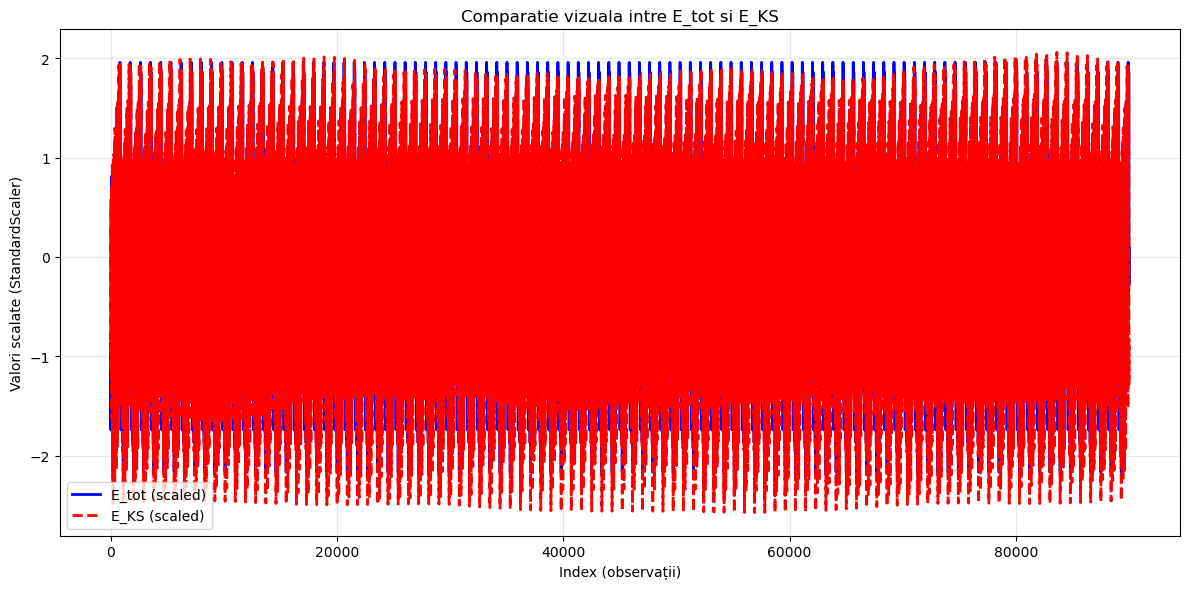

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(range(len(y_scaled)), y_scaled, 
         label='E_tot (scaled)', 
         color='blue', linewidth=2)

plt.plot(range(len(X_scaled)), X_scaled[:,1], 
         label='E_KS (scaled)', 
         color='red', linestyle='--', linewidth=2)

plt.xlabel("Index (observații)")
plt.ylabel("Valori scalate (StandardScaler)")
plt.title("Comparatie vizuala intre E_tot si E_KS")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
import numpy as np

def create_sequences_multi_step(X, y, sequence_length, out_steps):
    X_sequences = []
    y_sequences = []

    total_samples = len(X)

    # mergem pana la punctul unde mai putem lua o fereastra completa
    last_start = total_samples - sequence_length - out_steps + 1

    for start_idx in range(last_start):
        end_idx = start_idx + sequence_length              # capatul ferestrei de intrare
        out_end_idx = end_idx + out_steps                  # capatul ferestrei de iesire

        X_window = X[start_idx:end_idx]                    # input: secventa din trecut
        y_window = y[end_idx:out_end_idx]                  # output: secventa din viitor

        X_sequences.append(X_window)
        y_sequences.append(y_window)

    return np.array(X_sequences), np.array(y_sequences)

# Parametri
SEQUENCE_LENGTH = 200   # cate timesteps din trecut folosim
OUT_STEPS = 20          # cate timesteps vrem sa prezicem

# Creare secvente
X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, SEQUENCE_LENGTH, OUT_STEPS)

print(f"X shape: {X_seq.shape}")  # (num_samples, 200, num_features)
print(f"y shape: {y_seq.shape}")  # (num_samples, 20)


X shape: (89781, 200, 4)
y shape: (89781, 20)


In [14]:
total_samples = len(X_seq)
train_size = int(total_samples * 0.7)   # 70% pentru antrenare
val_size = int(total_samples * 0.15)    # 15% pentru validare
test_size = total_samples - train_size - val_size  # restul pentru test

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Dimensiuni train: {X_train.shape}, {y_train.shape}")
print(f"Dimensiuni val: {X_val.shape}, {y_val.shape}")
print(f"Dimensiuni test: {X_test.shape}, {y_test.shape}")


Dimensiuni train: (62846, 200, 4), (62846, 20)
Dimensiuni val: (13467, 200, 4), (13467, 20)
Dimensiuni test: (13468, 200, 4), (13468, 20)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_optimized_lstm_model(input_shape, out_steps=20):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        LSTM(64, return_sequences=False, dropout=0.2),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(out_steps)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# Construieste modelul
model = build_optimized_lstm_model(input_shape=(200, 4), out_steps=20)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


I0000 00:00:1755502474.957079    6805 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5345 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 128)       │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,732 (483.33 KB)

 Trainable params: 123,348 (481.83 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



# Salveaza modelul final
model.save('nmetil_model_10-e_tot.keras')

# Evaluare
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Epoch 1/20


I0000 00:00:1755502497.227960    9228 cuda_dnn.cc:529] Loaded cuDNN version 90300


982/982 ━━━━━━━━━━━━━━━━━━━━ 224s 225ms/step - loss: 0.1413 - mae: 0.2574 - val_loss: 0.0424 - val_mae: 0.1304 - learning_rate: 0.0010
Epoch 2/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 229s 233ms/step - loss: 0.0476 - mae: 0.1568 - val_loss: 0.0209 - val_mae: 0.0989 - learning_rate: 0.0010
Epoch 3/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 231s 236ms/step - loss: 0.0327 - mae: 0.1304 - val_loss: 0.0172 - val_mae: 0.0929 - learning_rate: 0.0010
Epoch 4/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 224s 228ms/step - loss: 0.0248 - mae: 0.1134 - val_loss: 0.0103 - val_mae: 0.0757 - learning_rate: 0.0010
Epoch 5/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 231s 235ms/step - loss: 0.0206 - mae: 0.1031 - val_loss: 0.0171 - val_mae: 0.1010 - learning_rate: 0.0010
Epoch 6/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 204s 207ms/step - loss: 0.0181 - mae: 0.0951 - val_loss: 0.0061 - val_mae: 0.0591 - learning_rate: 0.0010
Epoch 7/20
982/982 ━━━━━━━━━━━━━━━━━━━━ 216s 220ms/step - loss: 0.0135 - mae: 0.0832 - val_loss: 0.0046 - val_mae: 0.0522 - learning_ra

🏆 Performanța modelului:
   ├── MSE: 0.00006104 eV²
   ├── MAE: 0.00561878 eV
   ├── RMSE: 0.00781264 eV
   ├── MAPE: 0.00%
   └── R²: 0.996129 (99.61%)

📏 Context E_KS:
   ├── Range: [-1300.586680, -1300.068110] eV
   └── Amplitudine: 0.518570 eV


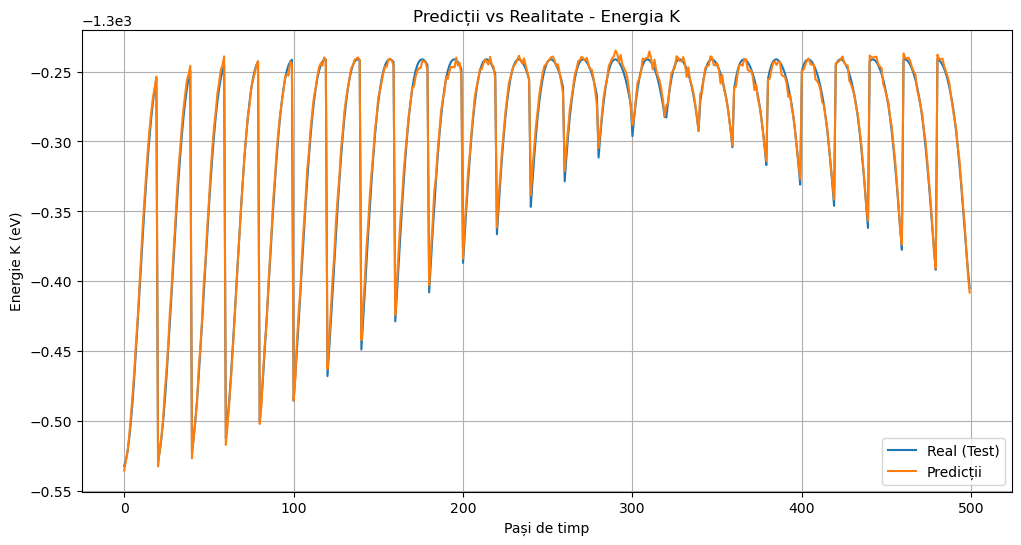

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictii pe setul de test
y_pred = model.predict(X_test, verbose=0)

# Inversare scalare pentru a reveni la valorile originale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calcul metrici
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# MAPE
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"🏆 Performanța modelului:")
print(f"   ├── MSE: {mse:.8f} eV²")
print(f"   ├── MAE: {mae:.8f} eV")
print(f"   ├── RMSE: {rmse:.8f} eV")
print(f"   ├── MAPE: {mape:.2f}%")
print(f"   └── R²: {r2:.6f} ({r2*100:.2f}%)")

print(f"\n📏 Context E_KS:")
print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
print(f"   └── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")

# Plot comparativ predicții vs realitate
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:500], label='Real (Test)')
plt.plot(y_pred_original[:500], label='Predicții')
plt.title('Predicții vs Realitate - Energia K')
plt.xlabel('Pași de timp')
plt.ylabel('Energie K (eV)')
plt.legend()
plt.grid(True)
plt.show()

# Salvare model final
# model.save('final_lstm_model.keras')
# print("Modelul a fost salvat ca 'final_lstm_model.keras'")


421/421 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step
(13468, 20) (13468, 200, 4) (13468, 20)
(269360, 1) (269360, 1)


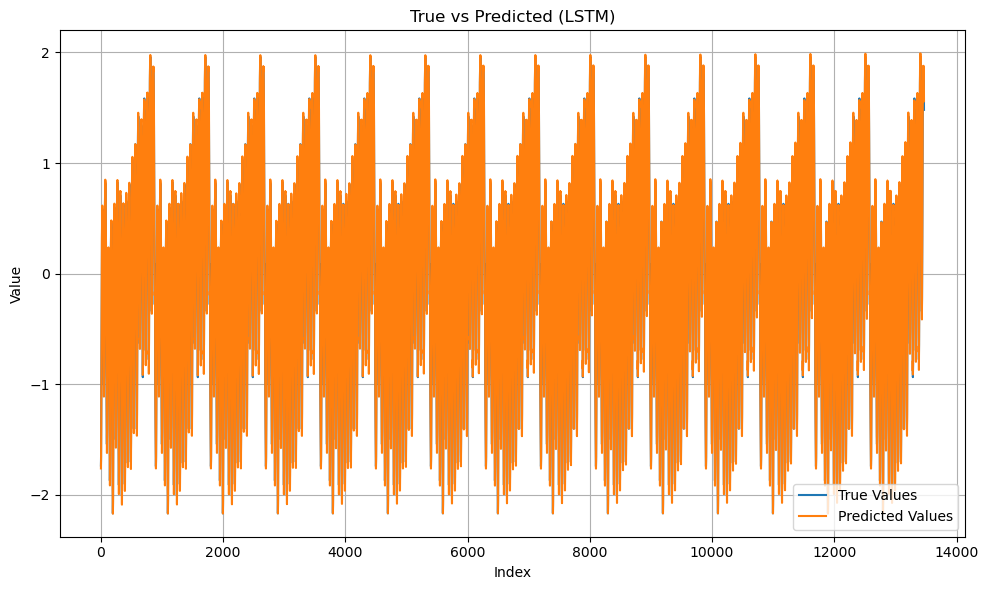

In [ ]:
import matplotlib.pyplot as plt

# Predicții
predictions = model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scaling (dacă folosești scaler pe ieșire)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Grafic True vs Predicted pentru prima valoare din fiecare fereastra
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values')
plt.plot(predictions[:, 0], label='Predicted Values')
plt.title('True vs Predicted (LSTM)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🏆 Performanța modelului (date normalizate):
   ├── MSE: 0.00942866
   ├── MAE: 0.07072285
   ├── RMSE: 0.09710131
   ├── MAPE: 49.15%
   └── R²: 0.990559 (99.06%)


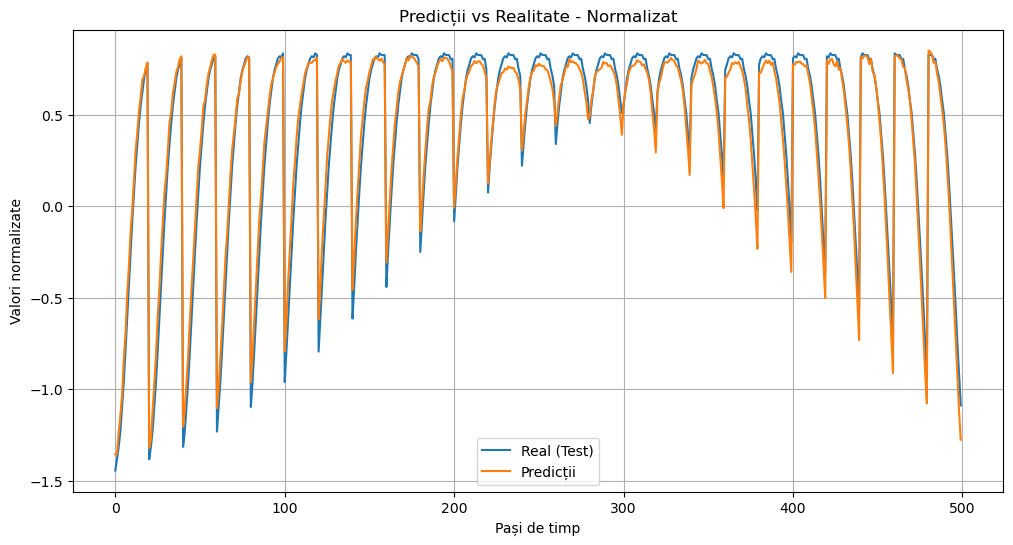

In [ ]:
# Predictii pe setul de test (date normalizate)
y_pred_norm = model.predict(X_test, verbose=0).flatten()
y_test_norm = y_test.flatten()

# Calcul metrici pe valori normalizate
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)
r2_norm = r2_score(y_test_norm, y_pred_norm)
mape_norm = np.mean(np.abs((y_test_norm - y_pred_norm) / y_test_norm)) * 100

print(f"   Performanța modelului (date normalizate):")
print(f"   ├── MSE: {mse_norm:.8f}")
print(f"   ├── MAE: {mae_norm:.8f}")
print(f"   ├── RMSE: {rmse_norm:.8f}")
print(f"   ├── MAPE: {mape_norm:.2f}%")
print(f"   └── R²: {r2_norm:.6f} ({r2_norm*100:.2f}%)")

# Plot pe date normalizate
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[:500], label='Real (Test)')
plt.plot(y_pred_norm[:500], label='Predicții')
plt.title('Predicții vs Realitate - Normalizat')
plt.xlabel('Pași de timp')
plt.ylabel('Valori normalizate')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import plotly.graph_objects as go

# Predictii pe test set și inversare scalare
y_pred = model.predict(X_test, verbose=0)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_test_original,
    mode='lines',
    name='True Values'
))
fig.add_trace(go.Scatter(
    y=y_pred_original,
    mode='lines',
    name='Predicted Values'
))

fig.update_layout(
    title='Predicții vs Realitate - Energia K-Tot (LSTM)',
    xaxis_title='Index',
    yaxis_title='Energie (eV)'
)

# Salvează și afișează graficul în browser
fig.write_html("test_lstm_full.html", auto_open=True)
fig.show(renderer="browser")


In [26]:
import plotly.graph_objects as go

# Predictii pe test set și inversare scalare
y_pred = model.predict(X_test, verbose=0)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Alege intervalul dorit
start_idx = 100   # index de start
end_idx = 1100    # index de final

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_test_original[start_idx:end_idx],
    mode='lines+markers',
    name='True Values'
))
fig.add_trace(go.Scatter(
    y=y_pred_original[start_idx:end_idx],
    mode='lines+markers',
    name='Predicted Values'
))

fig.update_layout(
    title=f'Predicții vs Realitate - Energia K (LSTM) [Index {start_idx}–{end_idx}]',
    xaxis_title='Index',
    yaxis_title='Energie (eV)'
)

# Salvează și afișează graficul în browser
fig.write_html("test_lstm_interval.html", auto_open=True)
fig.show(renderer="browser")
